In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sinkhorn(A,p,q,max_iter=20,eps = 1e-8,ground_truth=None):
    (n,m) = A.shape
    d_0 = np.ones(m)
    
    # test code for fiedler number
    fiedlers = []
    
    # if row sum is zero, skip
    r = np.sum(A,axis=1)
    if min(r) == 0:
        print('zero detected')
        return None, None, None, None
    
    # initial projective distance
    original_distance = np.log(np.max(r)/np.min(r))
    alternative_distance = np.linalg.norm(r/p-np.ones((n,)))

    
    # ratio of projective distance
    ratios = []
    
    svs = []
    
    svs_max = []
    
    for j in range(max_iter):
        
        print('iteration ', j)
        #print('scaled entries should be monotonic: ', A[1,1]/q[1])

        # fiedler number
        #L = np.diag(np.sum(A.T.dot(A),axis=1))-A.T.dot(A)
        scaled_A = np.diag(1/q)@A.T@np.diag(1/p)@A
        L = np.diag(np.sum(scaled_A,axis=1))-scaled_A
        
        alternative_A = np.diag(1/q)@A.T@np.diag(1/r)@A
        print('spectrum: ', np.sort(np.linalg.eigvals(alternative_A)))
        
        
        # alternative L, symmetric but not valid yet
        #scaled_A = np.diag(np.sqrt(1/q))@A.T@np.diag(1/p)@A@np.diag(np.sqrt(1/q))
        #L = np.diag(scaled_A@np.sqrt(q))-scaled_A
        
        # alternative L, valid
        #scaled_A = np.diag(1/p)@A@np.diag(1/q)@A.T
        #L = np.diag(np.sum(scaled_A,axis=1))-scaled_A
        
        #s, _ = np.linalg.eig(L)
        #print(np.sort(s))

        
        # fiedler number vs. second smallest singular value of L
        fiedlers.append(np.sort(np.linalg.eigvals(L))[1])
        print('fiedler number ', np.sort(np.linalg.eigvals(L))[1])
        #print(np.sort(np.linalg.eigvals(L)))
        #_, s, _ = np.linalg.svd(L)
        #fiedlers.append(np.sort(s)[1])
        #print('second smallest singular value of L: ', np.sort(s)[1])
        
        #second largest singular value and second largest eigenvalue have subtle difference
        #_, s, _ = np.linalg.svd(scaled_A)
        #svs.append((np.sort(s)[-2]))
        svs.append(np.sort(np.linalg.eigvals(scaled_A))[-2])
        #print(np.sort(np.linalg.eigvals(scaled_A)))
        
        # sinkhorn row normalization
        d_1 = p/np.sum(A,axis=1)
        A = (A.T*d_1).T
        
        print(A)
        # new column sum 
        c = np.sum(A,axis = 0)
        
        ###
        ratio_1 = np.log(np.max(q/c)/np.min(q/c))/np.log(np.max(p/r)/np.min(p/r))
        print('first step contraction ratio: ', ratio_1)
        ###
    
        # sinkhorn column normalization
        d_0 = q/np.sum(A,axis=0)
        A = A*d_0.T
        
        print(A)
        # new row sum
        r = np.sum(A,axis=1)
        
        ###
        ratio_2 = np.log(np.max(p/r)/np.min(p/r))/np.log(np.max(q/c)/np.min(q/c))
        print('second step contraction ratio: ', ratio_2)
        ###
        
        #print(r/p)
        #print(np.sum(r/p))
        # ratio of distances
        ratios.append(np.log(np.max(p/r)/np.min(p/r))/original_distance)
    
        print('contraction factor: ', ratios[-1])        
        print('singular value squared: ', svs[-1])
        print('old fiedler factor: ', 1-fiedlers[-1])
        #print('fiedler factor: ', svs_max[-1]-m/n*fiedlers[-1])
        #print('new fidler factor: ', svs_max[-1]+m/n*svs[-1])
        
        print('alternative contraction factor: ', 
              np.linalg.norm(r/p-np.ones((n,)))/alternative_distance)

        original_distance = np.log(np.max(p/r)/np.min(p/r))
        alternative_distance = np.linalg.norm(r/p-np.ones((n,)))

    
    return d_0, A, fiedlers,ratios,svs,svs_max

In [3]:
def generate_data(m,n,uniform=True):
    
    # generate matrix 
    A = np.random.randint(5, size=(n,m))
    
    A[1,1] = 1
    
    if uniform == True:
        p = np.ones((n,))
        q = np.ones((m,))*n/m
    else:
        #p = np.random.uniform(size=(n,))
        #p = p/np.sum(p)
        p = np.ones((n,))
        q = np.random.uniform(size=(m,))
        q = q/np.sum(q)*np.sum(p)

    r = np.sum(A,axis=1)
    # if row is zero, set first two entries to be 1
    zeros = (r==0)
    if np.sum(zeros)>0:
        A[zeros,0] = 1 
        A[zeros,1] = 1
    # if row has one non-negative entry, set all entries to be 1
    ones = (r==1)
    if np.sum(ones)>0:
        A[ones,:] = 1
    
    # need to fix here because A can have zero columns
    # ensure A is column normalized
    
    if uniform == True:
        A = A/np.sum(A,axis=0)*n/m
    else:
        d_0 = q/np.sum(A,axis=0)
        A = A*d_0.T
    
    return A,p,q

### Example 1

In [4]:
A = np.array([[3,1],[0,2]])
p = np.array([3,3])
q = np.array([3,3])

In [5]:
A_final = np.array([[2,2],[0,2]])
scaled_A = np.diag(1/q)@A_final.T@np.diag(1/p)@A_final
L = np.diag(np.sum(scaled_A,axis=1))-scaled_A

print('final fiedler factor', 1-np.sort(np.linalg.eigvals(L))[1])

final fiedler factor 0.11111111111111116


In [6]:
scaled_A

array([[0.44444444, 0.44444444],
       [0.44444444, 0.88888889]])

In [7]:
_, scaled_A, fiedlers, ratios, svs, svs_max = sinkhorn(A,p,q,max_iter=50)

iteration  0
spectrum:  [0.5 1. ]
fiedler number  0.6666666666666665
[[2.25 0.75]
 [0.   3.  ]]
first step contraction ratio:  0.7369655941662061
[[3.  0.6]
 [0.  2.4]]
second step contraction ratio:  0.7937446542303992
contraction factor:  0.584962500721156
singular value squared:  0.3771609693928901
old fiedler factor:  0.3333333333333335
alternative contraction factor:  0.5999999999999996
iteration  1
spectrum:  [0.66666667 1.        ]
fiedler number  0.4
[[2.5 0.5]
 [0.  3. ]]
first step contraction ratio:  0.82984264217244
[[3.         0.42857143]
 [0.         2.57142857]]
second step contraction ratio:  0.8549949777153293
contraction factor:  0.7095112913514553
singular value squared:  0.5838750305026861
old fiedler factor:  0.6
alternative contraction factor:  0.7142857142857146
iteration  2
spectrum:  [0.75 1.  ]
fiedler number  0.2857142857142856
[[2.625 0.375]
 [0.    3.   ]]
first step contraction ratio:  0.8735839051042344
[[3.         0.33333333]
 [0.         2.66666667]]


contraction factor:  0.9770094453991063
singular value squared:  0.9718334757046212
old fiedler factor:  0.9764705882352942
alternative contraction factor:  0.9770114942528806
iteration  42
spectrum:  [0.97727273 1.        ]
fiedler number  0.022988505747126485
[[2.96590909 0.03409091]
 [0.         3.        ]]
first step contraction ratio:  0.9886353796287136
[[3.         0.03370787]
 [0.         2.96629213]]
second step contraction ratio:  0.9887630937978263
contraction factor:  0.9775261765996754
singular value squared:  0.9724756880975797
old fiedler factor:  0.9770114942528735
alternative contraction factor:  0.9775280898876345
iteration  43
spectrum:  [0.97777778 1.        ]
fiedler number  0.022471910112359585
[[2.96666667 0.03333333]
 [0.         3.        ]]
first step contraction ratio:  0.9888879691574567
[[3.         0.03296703]
 [0.         2.96703297]]
second step contraction ratio:  0.9890100993257117
contraction factor:  0.9780201885984176
singular value squared:  0.973

### Example 2

In [8]:
A = np.array([[1,0,3/2],[0,1,1/2],[1,0,3/2],[0,1,1/2]])
p = np.array([2,2,2,2])
q = np.array([2,2,4])
A_final = np.array([[1,0,1],[0,1,1],[1,0,1],[0,1,1]])
scaled_A = np.diag(1/q)@A_final.T@np.diag(1/p)@A_final
L = np.diag(np.sum(scaled_A,axis=1))-scaled_A
print('final fiedler factor', 1-np.sort(np.linalg.eigvals(L))[1])

final fiedler factor 0.4999999999999998


In [9]:
_, scaled_A, fiedlers, ratios, svs, svs_max = sinkhorn(A,p,q,max_iter=15)

iteration  0
spectrum:  [0.  0.6 1. ]
fiedler number  0.3169872981077806
[[0.8        0.         1.2       ]
 [0.         1.33333333 0.66666667]
 [0.8        0.         1.2       ]
 [0.         1.33333333 0.66666667]]
first step contraction ratio:  1.0000000000000002
[[1.         0.         1.28571429]
 [0.         1.         0.71428571]
 [1.         0.         1.28571429]
 [0.         1.         0.71428571]]
second step contraction ratio:  0.5631707946263248
contraction factor:  0.5631707946263248
singular value squared:  0.5
old fiedler factor:  0.6830127018922194
alternative contraction factor:  0.5714285714285714
iteration  1
spectrum:  [0.      0.53125 1.     ]
fiedler number  0.42857142857142855
[[0.875      0.         1.125     ]
 [0.         1.16666667 0.83333333]
 [0.875      0.         1.125     ]
 [0.         1.16666667 0.83333333]]
first step contraction ratio:  0.9999999999999994
[[1.         0.         1.14893617]
 [0.         1.         0.85106383]
 [1.         0.       

### Example 3

In [149]:
8/35

0.22857142857142856

In [150]:
A = np.array([[1,0,5],[0,1,1],[1,0,5],[0,1,1]])
p = np.array([4,5,4,5])
q = np.array([2,2,14])
A_final = np.array([[1,0,3],[0,1,4],[1,0,3],[0,1,4]])
scaled_A = np.diag(1/q)@A_final.T@np.diag(1/p)@A_final
L = np.diag(np.sum(scaled_A,axis=1))-scaled_A
print('final fiedler factor', 1-np.sort(np.linalg.eigvals(L))[1])
print('spectrum', np.sort(np.linalg.eigvals(scaled_A)))

final fiedler factor 0.22857142857142865
spectrum [-4.57098424e-17  2.28571429e-01  1.00000000e+00]


In [151]:
scaled_A

array([[0.25      , 0.        , 0.75      ],
       [0.        , 0.2       , 0.8       ],
       [0.10714286, 0.11428571, 0.77857143]])

In [152]:
w,v = np.linalg.eig(scaled_A)
print(v)

[[ 0.57735027  0.78067454 -0.58834841]
 [ 0.57735027 -0.62453963 -0.78446454]
 [ 0.57735027 -0.02230499  0.19611614]]


In [153]:
v[:,1].dot(scaled_A).dot(v[:,1])

0.2285714285714286

In [154]:
v[:,1]/v[-1,1]

array([-35.,  28.,   1.])

In [155]:
p

array([4, 5, 4, 5])

In [156]:
q

array([ 2,  2, 14])

In [157]:
_, scaled_A, fiedlers, ratios, svs, svs_max = sinkhorn(A,p,q,max_iter=15)

iteration  0
fiedler number  0.22433468621266867
[[0.66666667 0.         3.33333333]
 [0.         2.5        2.5       ]
 [0.66666667 0.         3.33333333]
 [0.         2.5        2.5       ]]
first step contraction ratio:  1.0
[[1. 0. 4.]
 [0. 1. 3.]
 [1. 0. 4.]
 [0. 1. 3.]]
second step contraction ratio:  0.3376471577643185
[1.25 0.8  1.25 0.8 ]
4.1
contraction factor:  0.4062280271500246
singular value squared:  0.20147282123776303
old fiedler factor:  0.7756653137873313
alternative contraction factor:  0.4099180245918029
iteration  1
fiedler number  0.6603373023624117
[[0.8  0.   3.2 ]
 [0.   1.25 3.75]
 [0.8  0.   3.2 ]
 [0.   1.25 3.75]]
first step contraction ratio:  1.0
[[1.         0.         3.22302158]
 [0.         1.         3.77697842]
 [1.         0.         3.22302158]
 [0.         1.         3.77697842]]
second step contraction ratio:  0.22381606162846712
[1.0557554  0.95539568 1.0557554  0.95539568]
4.022302158273382
contraction factor:  0.22381606162846712
singular v

In [158]:
scaled_A

array([[1., 0., 3.],
       [0., 1., 4.],
       [1., 0., 3.],
       [0., 1., 4.]])

### Example 4

In [159]:
3/14

0.21428571428571427

In [160]:
A = np.array([[1,0,5],[0,1,0.5],[1,0,5],[0,0,3.5]])
p = np.array([4,5,4,4])
q = np.array([2,1,14])
A_final = np.array([[1,0,3],[0,1,4],[1,0,3],[0,0,4]])
scaled_A = np.diag(1/q)@A_final.T@np.diag(1/p)@A_final
L = np.diag(np.sum(scaled_A,axis=1))-scaled_A
print('final fiedler factor', 1-np.sort(np.linalg.eigvals(L))[1])
print('spectrum', np.sort(np.linalg.eigvals(scaled_A)))

final fiedler factor 0.22110322250073722
spectrum [0.06461106 0.22110322 1.        ]


In [161]:
scaled_A

array([[0.25      , 0.        , 0.75      ],
       [0.        , 0.2       , 0.8       ],
       [0.10714286, 0.05714286, 0.83571429]])

In [162]:
_, scaled_A, fiedlers, ratios, svs, svs_max = sinkhorn(A,p,q,max_iter=20)

iteration  0
fiedler number  0.10617831022682488
[[0.66666667 0.         3.33333333]
 [0.         3.33333333 1.66666667]
 [0.66666667 0.         3.33333333]
 [0.         0.         4.        ]]
first step contraction ratio:  0.9999999999999999
[[1.         0.         3.78378378]
 [0.         1.         1.89189189]
 [1.         0.         3.78378378]
 [0.         0.         4.54054054]]
second step contraction ratio:  0.4513777411440706
[1.19594595 0.57837838 1.19594595 1.13513514]
4.105405405405405
contraction factor:  0.5240333292846063
singular value squared:  0.20020023386524188
old fiedler factor:  0.8938216897731751
alternative contraction factor:  0.5208549877288581
iteration  1
fiedler number  0.4000425648864787
[[0.83615819 0.         3.16384181]
 [0.         1.72897196 3.27102804]
 [0.83615819 0.         3.16384181]
 [0.         0.         4.        ]]
first step contraction ratio:  1.0
[[1.         0.         3.25720454]
 [0.         1.         3.36755376]
 [1.         0.    

### general case

In [163]:
m_individual = 5
n_individual = 10
A, p, q = generate_data(m=m_individual,n=n_individual,uniform=False)

In [164]:
_, scaled_A, fiedlers, ratios, svs, svs_max = sinkhorn(A,p,q,max_iter=30)

iteration  0
fiedler number  0.8955470933784668
[[0.         0.         0.04713637 0.83219443 0.12066919]
 [0.         0.68909935 0.31090065 0.         0.        ]
 [0.48180587 0.12756509 0.0191845  0.33870298 0.03274156]
 [0.43546316 0.30745383 0.13871381 0.         0.11836919]
 [0.         0.         0.15956361 0.70427536 0.13616103]
 [0.57237808 0.02525757 0.02279089 0.30178051 0.07779295]
 [0.         0.         0.19683936 0.57920104 0.22395959]
 [0.         0.71070409 0.10688268 0.         0.18241323]
 [0.47601147 0.1120275  0.01263585 0.33462959 0.06469559]
 [0.34882513 0.12314201 0.01388948 0.49043865 0.02370473]]
first step contraction ratio:  0.3973606584693924
[[0.         0.         0.02048811 0.91706022 0.09389887]
 [0.         0.36210083 0.13513485 0.         0.        ]
 [0.77908373 0.06703159 0.00833866 0.37324334 0.02547788]
 [0.70414722 0.16155768 0.0602928  0.         0.09210913]
 [0.         0.         0.06935529 0.77609618 0.10595387]
 [0.92553968 0.01327209 0.00990

In [137]:
final_A = np.diag(1/p)@scaled_A@np.diag(1/q)@scaled_A.T
L = np.diag(np.sum(final_A,axis=1))-final_A
print('final fiedler factor', 1-np.sort(np.linalg.eigvals(L))[1])
print('spectrum', np.sort(np.linalg.eigvals(final_A)))

final fiedler factor 0.5885953176050602
spectrum [-3.43597628e-17+0.00000000e+00j -1.26981004e-17-2.63234055e-17j
 -1.26981004e-17+2.63234055e-17j  1.30530646e-17-9.46917908e-18j
  1.30530646e-17+9.46917908e-18j  1.15375349e-02+0.00000000e+00j
  4.56928454e-02+0.00000000e+00j  1.42003870e-01+0.00000000e+00j
  5.88595317e-01+0.00000000e+00j  1.00000000e+00+0.00000000e+00j]


In [138]:
np.sum(scaled_A,axis=1)-p

array([ 1.36279370e-08, -1.73435547e-08,  3.03656547e-08, -3.02829256e-08,
        1.98697423e-08, -1.82021914e-08,  2.31603989e-08, -2.88098180e-08,
       -1.55379580e-08,  2.31527146e-08])

In [139]:
np.sum(scaled_A,axis=0)-q

array([ 4.44089210e-16,  0.00000000e+00,  4.44089210e-16, -1.11022302e-16,
       -2.77555756e-17])

In [140]:
p

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [86]:
fiedlers

[0.10617831022682488,
 0.4000425648864787,
 0.6976028530679423,
 0.7703211723201593,
 0.7778290473842312,
 0.7787108428058142,
 0.7788586783911405,
 0.7788885371188429,
 0.7788949668377214,
 0.7788963778607896,
 0.7788966891821499,
 0.7788967579748587,
 0.7788967731825314,
 0.7788967765448299,
 0.7788967772882349,
 0.7788967774526039,
 0.7788967774889455,
 0.7788967774969812,
 0.7788967774987582,
 0.7788967774991509]

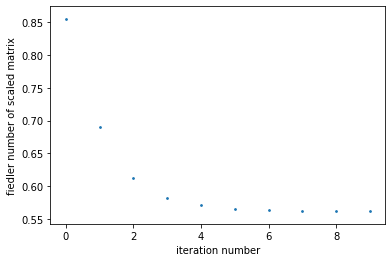

In [332]:
plt.scatter(np.arange(len(fiedlers)),fiedlers,s=3)
plt.xlabel('iteration number')
plt.ylabel('fiedler number of scaled matrix')
plt.show()

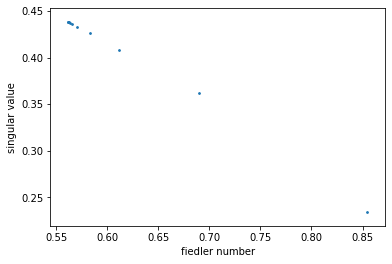

In [333]:
plt.scatter(fiedlers,svs,s=3)
plt.xlabel('fiedler number')
plt.ylabel('singular value')
plt.show()

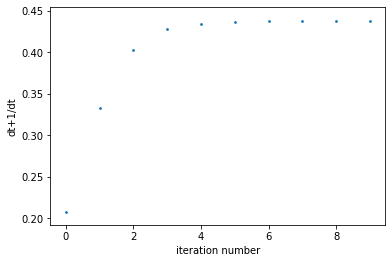

In [334]:
plt.scatter(np.arange(len((ratios))),(ratios),s=3)
plt.xlabel('iteration number')
plt.ylabel('dt+1/dt')
plt.show()

### relationship between d_t+1/d_t vs. fiedler number

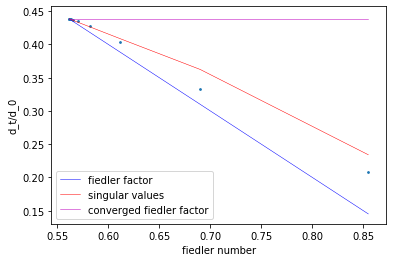

0.6571785891687828


In [335]:
from sklearn.linear_model import LinearRegression
#last = 0
#reg = LinearRegression(fit_intercept=True).fit(np.array(fiedlers)[last:,np.newaxis], np.array(ratios)[last:])
#plt.plot(np.array(fiedlers)[last:,np.newaxis],reg.predict(np.array(fiedlers)[last:,np.newaxis]),c='r',linewidth=0.5)
fiedlers = np.array(fiedlers)
ratios = np.array(ratios)
svs = np.array(svs)
svs_max = np.array(svs_max)

fiedler_factor = -fiedlers + 1
plt.scatter(fiedlers, ratios,s=3)

plt.plot(fiedlers, fiedler_factor,c='b',linewidth='0.5',label='fiedler factor')

#plt.plot(fiedlers, m_individual/n_individual*svs+svs_max,c='g',linewidth='0.5')

plt.plot(fiedlers, svs, c='r', linewidth='0.5',label='singular values')

plt.plot(fiedlers, fiedler_factor[-1]*np.ones((len(fiedlers),)), c='m', linewidth='0.5',label='converged fiedler factor')

factors = np.array([1/(1+np.exp(-1*t)) for t in np.arange(len(fiedlers))])
#plt.plot(fiedlers, (-m_individual/n_individual*fiedlers+1)*factors)
#plt.plot(fiedlers, (-m_individual/n_individual*fiedlers*0.4+1))
#plt.plot(fiedlers, (-m_individual/n_individual*fiedlers+1))
#plt.axvline(x=fiedlers[-1])
plt.xlabel('fiedler number')
plt.ylabel('d_t/d_0')
plt.legend()
plt.show()
print(fiedlers[-1]/fiedlers[0])
#print(reg.coef_)
#print(reg.intercept_)

In [336]:
fiedlers

array([0.85477259, 0.69016334, 0.61170749, 0.5825465 , 0.57059657,
       0.56550679, 0.56330323, 0.56234246, 0.56192227, 0.56173825])

In [337]:
ratios

array([0.20818691, 0.33326729, 0.4030501 , 0.42786705, 0.43466131,
       0.43669267, 0.43763096, 0.43805855, 0.4382511 , 0.43833706])

In [338]:
fiedler_factor

array([0.14522741, 0.30983666, 0.38829251, 0.4174535 , 0.42940343,
       0.43449321, 0.43669677, 0.43765754, 0.43807773, 0.43826175])

In [339]:
svs

array([0.23412386, 0.3622889 , 0.40859384, 0.42600329, 0.43309372,
       0.43610063, 0.43739953, 0.43796527, 0.43821257, 0.43832085])

In [340]:
(ratios<=fiedler_factor[-1])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [341]:
scaled_A.dot(np.diag(1/q))

array([[0.17879176, 0.0552667 , 0.        , 0.        , 0.39816954],
       [0.05393904, 0.01667321, 0.22962521, 0.07931497, 0.03003058],
       [0.0322271 , 0.11954146, 0.20579221, 0.04738853, 0.05382736],
       [0.14068606, 0.17395108, 0.        , 0.        , 0.15665405],
       [0.05795293, 0.05374186, 0.18503463, 0.17043443, 0.14519392],
       [0.06522057, 0.01512035, 0.20823908, 0.09590396, 0.08170105],
       [0.17048168, 0.07904693, 0.        , 0.12534288, 0.        ],
       [0.16305822, 0.07560491, 0.        , 0.23976989, 0.        ],
       [0.05365401, 0.09951063, 0.17130886, 0.11834377, 0.13442351],
       [0.08398863, 0.31154287, 0.        , 0.12350157, 0.        ]])

In [342]:
M = scaled_A.dot(np.diag(1/q))
m = M.shape[1]
for i in range(m):
    for j in range(i, m):
        print(i,j)
        I = (np.multiply(M[:,i],M[:,j])>0)
        numerator = M[:,i].dot(1-I)
        denominator = M[:,j].dot(1-I)
        if np.sum(I)>0 and numerator*denominator>0:
            print('numerator: ', numerator)
            print('denominator: ', denominator)
            print('numerator/denominator: ', numerator/denominator)
            print('individual ratios:', M[I,i]/M[I,j])
            print(M[I,i],M[I,j])

0 0
0 1
0 2
0 3
0 4
1 1
1 2
1 3
1 4
2 2
2 3
2 4
3 3
3 4
numerator:  0.48861434501818246
denominator:  0.554823581962084
numerator/denominator:  0.8806661448856256
individual ratios: [2.64113999 0.88038    1.17384    1.17384    0.88038   ]
[0.07931497 0.04738853 0.17043443 0.09590396 0.11834377] [0.03003058 0.05382736 0.14519392 0.08170105 0.13442351]
4 4


In [343]:
scaled_A.T*(1/p)

array([[0.8534884 , 0.25748581, 0.15384075, 0.67158533, 0.2766467 ,
        0.31133985, 0.81381903, 0.77838204, 0.2561252 , 0.40093192],
       [0.09830735, 0.02965799, 0.21263807, 0.30942085, 0.09559499,
        0.02689579, 0.14060718, 0.13448457, 0.17700761, 0.5541665 ],
       [0.        , 0.68047479, 0.60984771, 0.        , 0.54833441,
        0.61709882, 0.        , 0.        , 0.50765926, 0.        ],
       [0.        , 0.02880846, 0.01721227, 0.        , 0.06190451,
        0.03483385, 0.04552654, 0.08708825, 0.04298435, 0.04485774],
       [0.04815586, 0.00363199, 0.00651005, 0.01894623, 0.0175602 ,
        0.00988118, 0.        , 0.        , 0.0162576 , 0.        ]])

In [344]:
M = scaled_A.T*(1/p)
m = M.shape[1]
for i in range(m):
    for j in range(i, m):
        print(i,j)
        I = (np.multiply(M[:,i],M[:,j])>0)
        numerator = M[:,i].dot(1-I)
        denominator = M[:,j].dot(1-I)
        if np.sum(I)>0 and numerator*denominator>0:
            print('numerator: ', numerator)
            print('denominator: ', denominator)
            print('numerator/denominator: ', numerator/denominator)
            print('individual ratios:', M[I,i]/M[I,j])
            print(M[I,i],M[I,j])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
numerator:  0.048155863024303795
denominator:  0.045526537384473216
numerator/denominator:  1.057753692481065
individual ratios: [1.0487447  0.69916313]
[0.8534884  0.09830735] [0.81381903 0.14060718]
0 7
numerator:  0.048155863024303795
denominator:  0.08708825325660699
numerator/denominator:  0.5529547467488152
individual ratios: [1.09649035 0.73099357]
[0.8534884  0.09830735] [0.77838204 0.13448457]
0 8
0 9
numerator:  0.048155863024303795
denominator:  0.04485774231600541
numerator/denominator:  1.073524001387863
individual ratios: [2.12876138 0.17739678]
[0.8534884  0.09830735] [0.40093192 0.5541665 ]
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
3 3
3 4
3 5
3 6
numerator:  0.018946227838924395
denominator:  0.045526537384473216
numerator/denominator:  0.41615789224036154
individual ratios: [0.82522687 2.20060498]
[0.67158533 0.30942085] [0.81381903 0.14060718]
3 7
numerator:  0.018946227838924395
denominator:  0.08708825325660699


In [244]:
first step contraction ratio:  0.6754717283291146
second step contraction ratio:  0.7152135023250032

NameError: name 'ratio_1' is not defined

#### exact relation between dt+1/d_t and fiedler number, as a function of t

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


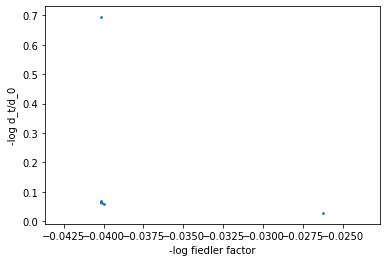

0.9725715129082957


In [473]:
#plt.scatter(-np.log(-m_individual/n_individual*fiedlers+1), -np.log(ratios),s=3)
plt.scatter(m_individual/n_individual*np.log(fiedlers), -np.log(1-ratios),s=3)

plt.xlabel('-log fiedler factor')
plt.ylabel('-log d_t/d_0')
plt.show()
print(fiedlers[-1]/fiedlers[0])
#print(reg.coef_)
#print(reg.intercept_)

### final Fiedler number vs. convergence rate

In [331]:
log_rates = []
lambdas = []
fiedler_bound = []
svs = []

m = 10
n = 30

for i in range(2000):
    print('iteration ', i)
    
    A, p, q = generate_data(m,n,uniform=True)
    
    _, scaled_A, fiedlers, ratios,_ = sinkhorn(A,p,q)
    
    # accept run if contraction ratio has stabilized
    last = -5
    if np.var(ratios[last:])<=1e-1:
        #plt.scatter(np.arange(len(ratios))+1, -np.log(ratios),s=3)
        #plt.xlabel('iteration')
        #plt.ylabel('-log(d_t/d_0)')
        #plt.scatter(fiedlers[last:], ratios[last:],s=3)
        #plt.xlabel('iteration')
        #plt.ylabel('(d_t/d_0)')
        #plt.show()
        
        #print('stabilized rate of convergence: ', -np.mean(np.log(ratios)[-5:]))
        log_rates.append(np.mean(ratios[last:]))
        
        # append final fiedler
        lambdas.append(fiedlers[-1])
        
        _, s, _ = np.linalg.svd(scaled_A)
        svs.append((np.sort(s)[-2])**2)
        
        fiedler_bound.append(fiedlers[-1]/fiedlers[0])

iteration  0
iteration  0
[3.144428   3.18756684 3.19565283 3.19709702 3.21991501 3.22298442
 3.33237204 3.37596223 3.41267598 3.48253915]
contraction factor:  0.07873595741325783
singular value squared:  0.7534909189498069
old fiedler factor:  0.1653001094586255
new factor:  0.7374433635640163
iteration  1
[2.95903907 2.96842402 2.96985659 2.98506731 2.99379595 3.00258284
 3.02876828 3.03266917 3.03495336 3.04391723]
contraction factor:  0.16365005048142622
singular value squared:  0.8904213341363745
old fiedler factor:  0.2949242640857286
new factor:  0.8949725487836709
iteration  2
[2.99266903 2.99371615 2.9946555  2.99721744 2.99957274 2.99966401
 3.00465772 3.00533398 3.00557906 3.00745887]
contraction factor:  0.17085768973307622
singular value squared:  0.8927653119609585
old fiedler factor:  0.2972316962606806
new factor:  0.8935798646657106
iteration  3
[2.99872087 2.99878073 2.99919113 2.99943985 2.99989557 3.00010584
 3.00069482 3.00091329 3.00093158 3.00134181]
contraction 

ValueError: too many values to unpack (expected 5)

In [571]:
A

array([[0.        , 0.        , 0.        , 0.2       , 0.2       ,
        0.15      , 0.17647059, 0.        , 0.15789474, 0.        ],
       [0.21428571, 0.        , 0.        , 0.2       , 0.        ,
        0.15      , 0.        , 0.25      , 0.        , 0.        ],
       [0.21428571, 0.23076923, 0.        , 0.2       , 0.2       ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.21428571, 0.23076923, 0.        , 0.2       , 0.        ,
        0.15      , 0.        , 0.25      , 0.        , 0.23076923],
       [0.21428571, 0.23076923, 0.        , 0.        , 0.2       ,
        0.        , 0.17647059, 0.25      , 0.        , 0.23076923],
       [0.        , 0.23076923, 0.3       , 0.        , 0.2       ,
        0.15      , 0.17647059, 0.25      , 0.15789474, 0.        ],
       [0.        , 0.23076923, 0.3       , 0.2       , 0.        ,
        0.15      , 0.17647059, 0.25      , 0.15789474, 0.        ],
       [0.21428571, 0.        , 0.3      

In [572]:
log_rates

[0.35539606021617115,
 0.3860497653385017,
 0.28437842990945916,
 0.3240037700816644,
 0.3181289381364223,
 0.2925189710321532,
 0.4081054429812321,
 0.3427895899149511,
 0.27197582704114504,
 0.31263684379416845,
 0.31170557809654414,
 0.3486217780065008,
 0.339458601257403,
 0.30065804466078216,
 0.35881407545862987,
 0.27796826389760537,
 0.28826647671696665,
 0.30839088302527384,
 0.2856326635930725,
 0.21264884293206218,
 0.32147556955380757,
 0.25321296448795244,
 0.33703590385914406,
 0.3380703725088325,
 0.25205646335681287,
 0.31342715977879837,
 0.36062833884608697,
 0.350016070599772,
 0.2797131007471279,
 0.2909199449084165,
 0.24924289772071645,
 0.2957282293618669,
 0.33911578906257206,
 0.27611137172933325,
 0.30109942641836296,
 0.3851494940768453,
 0.33867334491108375,
 0.33979995856224243,
 0.21558299778874374,
 0.305897100629916,
 0.3593334661399857,
 0.26507772777260663,
 0.42812935610214903,
 0.25296741917234156,
 0.3097963291422241,
 0.26986429684615976,
 0.335120

In [573]:
lambdas

[1.9338109166878956,
 1.8273452028689863,
 2.1477598794203545,
 2.0283667085250956,
 2.0366305325871545,
 2.1223006048758846,
 1.7756873583820085,
 1.9711602614859425,
 2.181199412941836,
 2.0586502402081575,
 2.0486225640809703,
 1.9436619733987022,
 1.9810306475700106,
 2.0980221359789764,
 1.9234452284975798,
 2.1587404626765956,
 2.135114924489564,
 2.054826847656319,
 2.142907570687608,
 2.2123435296038396,
 2.0355466273253393,
 2.2179486276157907,
 1.9926747212982234,
 1.9857201958422874,
 2.242478547964589,
 2.058547274107961,
 1.9180765718907438,
 1.9501707590773247,
 2.160782434346048,
 2.1292258074819066,
 2.251499753555546,
 2.112448022559374,
 1.9794163600739343,
 2.1717274051955138,
 2.096429673096465,
 1.8463265966743985,
 1.9838680453222448,
 1.982740320361082,
 2.2594454816820417,
 2.061022783179346,
 1.921996053702665,
 2.1376524185752044,
 1.7184594990544904,
 2.24216658001531,
 2.0702955416557693,
 2.1914712260885474,
 1.9947148365449685,
 2.1323977909714538,
 1.9917

In [574]:
log_rates = np.array(log_rates)
lambdas = np.array(lambdas)
svs = np.array(svs)
fiedler_bound = np.array(fiedler_bound)
initial_lambda = lambdas/fiedler_bound

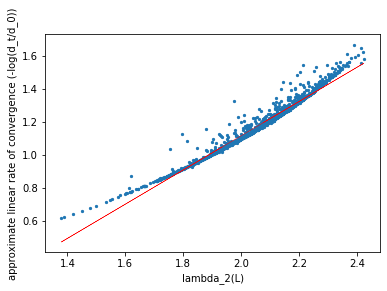

In [575]:
reg = LinearRegression(fit_intercept=True).fit(lambdas[:,np.newaxis], -np.log(log_rates))

plt.scatter(lambdas,-np.log(log_rates),s=5)
#plt.scatter(lambdas/fiedler_bound,log_rates,s=5)

plt.plot(lambdas[:,np.newaxis],reg.predict(lambdas[:,np.newaxis]),c='r',linewidth=0.5)
plt.xlabel('lambda_2(L)')
plt.ylabel('approximate linear rate of convergence (-log(d_t/d_0))')
#plt.xlim([0, 1.5*max(lambdas)])
#plt.ylim([0, 1.5*max(log_rates)])
plt.show()

In [576]:
print(reg.coef_)
print(reg.intercept_)

[1.04131154]
-0.9665552775633914


#### dt+1/d_t vs. lambda_2

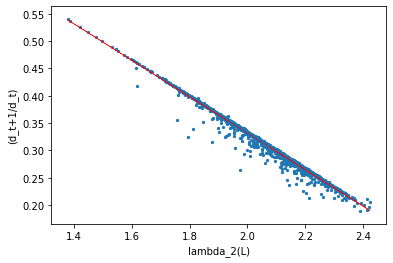

In [577]:
reg = LinearRegression(fit_intercept=True).fit(lambdas[:,np.newaxis], log_rates)

#plt.scatter(svs,np.exp(log_rates),s=5)
plt.scatter(lambdas,log_rates,s=5)
#plt.scatter(lambdas,-m/n*lambdas*0.6+1,s=5)
plt.plot(lambdas[:,np.newaxis],reg.predict(lambdas[:,np.newaxis]),c='r',linewidth=0.5)
plt.xlabel('lambda_2(L)')
plt.ylabel('(d_t+1/d_t)')
#plt.xlim([0, 1.5*max(lambdas)])
#plt.ylim([0, 1.5*max(log_rates)])
plt.show()

In [578]:
print(reg.coef_)
print(reg.intercept_)

[-0.3343571]
1.0002595781013137


In [579]:
# examine settings with zero Fiedler number: m=20; n=20
min(fiedler_bound)

0.5087475792011052

#### dt+1/d_t vs. initial lambda_2

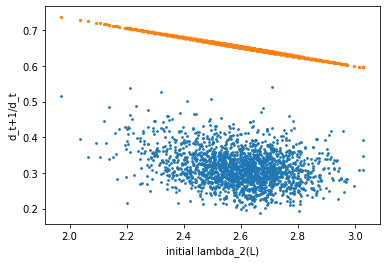

In [580]:
plt.scatter(initial_lambda,log_rates,s=3)
plt.scatter(initial_lambda,-m/n*initial_lambda*0.4+1,s=5)
plt.xlabel('initial lambda_2(L)')
plt.ylabel('d_t+1/d_t')
plt.show()

#### dt+1/dt vs. sigma^2

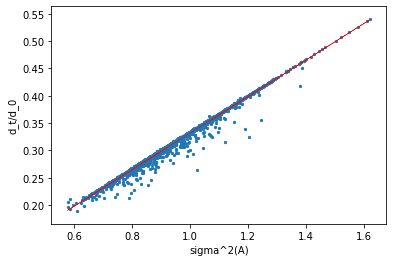

In [581]:
reg = LinearRegression(fit_intercept=True).fit(svs[:,np.newaxis], log_rates)
plt.scatter(svs,log_rates,s=5)

plt.plot(svs[:,np.newaxis],reg.predict(svs[:,np.newaxis]),c='r',linewidth=0.5)
plt.xlabel('sigma^2(A)')
plt.ylabel('d_t/d_0')
#plt.xlim([0, 1.5*max(lambdas)])
#plt.ylim([0, 1.5*max(log_rates)])
plt.show()

In [582]:
print(reg.coef_)
print(reg.intercept_)

[0.33435706]
-0.0028116939741518743


#### singular value vs. lambda_2

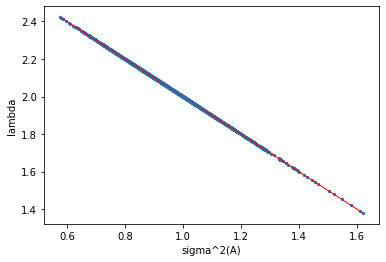

In [583]:
#plt.scatter(svs,np.exp(log_rates),s=5)
plt.scatter(svs,lambdas,s=5)
plt.xlabel('sigma^2(A)')
plt.ylabel('lambda')
reg = LinearRegression(fit_intercept=True).fit(svs[:,np.newaxis], lambdas)
plt.plot(svs[:,np.newaxis],reg.predict(svs[:,np.newaxis]),c='r',linewidth=0.5)
plt.show()

In [584]:
print(reg.coef_)
print(reg.intercept_)

[-0.99999988]
2.999999887727511
